## Group Project: EPA FE Analysis and Prediction

### Context: 


### Objective : 

* To identify the different factors that affect fuel economy in surveyed vehicles
* To make a model to predict if an employee will attrite or not


### Dataset :
The data contains (replace - demographic details), (replace - work-related metrics) and (replace - attrition flag).

* **Metric** - Definition


### Import the necessary libraries

In [1]:
# Note: go through later and removed unused dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

#for tuning the model
from sklearn.model_selection import GridSearchCV

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Read the dataset
Additionally, perform some cleaning and some column combination/drops as agreed upon during prior inspection of the data pool.

In [2]:
#reading the dataset

# use the commented out df definition to import only the columns specified in the above list
df = pd.read_csv('table_export_unclean.csv')

# drop columns decided to be unwanted for our analysis
drops = ['Real-World MPG_City','Real-World MPG_Hwy','Real-World CO2 (g/mi)','Real-World CO2_City (g/mi)',
        'Real-World CO2_Hwy (g/mi)','HP/Weight (lbs)','Ton-MPG (Real-World)','Transmission - Other','Fuel Delivery - Carbureted',
        'Fuel Delivery - Throttle Body Injection','Powertrain - Fuel Cell Vehicle (FCV)','Powertrain - Other (incl. CNG)','4 or Fewer Gears',
        '5 Gears','6 Gears','7 Gears','8 Gears','9 or More Gears']


df = df.drop(drops, axis = 1)

# erroneous entries requiring replacement
df = df.replace('-', np.NaN)
df = df.replace('Prelim. 2021', '2021')

# attempt to convert columns from object to numeric type wherever possible - df.infer_objects() wasn't cutting it
cols = df.columns
for col in cols:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# combine two transmission columns and two powertrain columns, dropping the originals
df['Transmission - Automatic + Lockup'] = df['Transmission - Automatic'] + df['Transmission - Lockup']
df['Powertrain - PHEV and Gas Hybrid'] = df['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] + df['Powertrain - Gasoline Hybrid']
df = df.drop(columns = ['Transmission - Automatic','Transmission - Lockup','Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)','Powertrain - Gasoline Hybrid'])

df.head()

,Manufacturer,Model Year,Regulatory Class,Vehicle Type,Production (000),Production Share,2-Cycle MPG,Real-World MPG,Weight (lbs),Footprint (sq. ft.),...,Powertrain - Gasoline,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV and Gas Hybrid
0,All,1975,All,All,10224.0,1.0,15.33300,13.05970,4060.399,NaN,...,0.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.770,NaN
1,All,1976,All,All,12334.0,1.0,16.70719,14.22136,4079.198,NaN,...,0.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,All,1977,All,All,14123.0,1.0,17.70553,15.06743,3981.818,NaN,...,0.996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,All,1978,All,All,14448.0,1.0,18.60678,15.83777,3715.238,NaN,...,0.991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.774,NaN
4,All,1979,All,All,13882.0,1.0,18.69594,15.91271,3655.465,NaN,...,0.980,NaN,NaN,NaN,NaN,NaN,3.3,NaN,0.754,NaN


### Dataset Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Manufacturer                                     5170 non-null   object 
 1   Model Year                                       5170 non-null   int64  
 2   Regulatory Class                                 5170 non-null   object 
 3   Vehicle Type                                     5170 non-null   object 
 4   Production (000)                                 3870 non-null   float64
 5   Production Share                                 3870 non-null   float64
 6   2-Cycle MPG                                      3972 non-null   float64
 7   Real-World MPG                                   3972 non-null   float64
 8   Weight (lbs)                                     3972 non-null   float64
 9   Footprint (sq. ft.)           

## Exploratory Data Analysis and Data Preprocessing

In [4]:
# What should we do about manufacturer = "All"?
df.Manufacturer.unique()

array(['All', 'GM', 'Honda', 'BMW', 'Ford', 'Hyundai', 'Stellantis',
       'Subaru', 'Mazda', 'Toyota', 'VW', 'Nissan', 'Mercedes', 'Tesla',
       'Kia'], dtype=object)

## Check summary statistics

In [5]:
df.drop(columns = ["Model Year", "Production Share"]).describe()

,Production (000),2-Cycle MPG,Real-World MPG,Weight (lbs),Footprint (sq. ft.),Engine Displacement,Horsepower (HP),Acceleration (0-60 time in seconds),HP/Engine Displacement,Drivetrain - Front,...,Powertrain - Gasoline,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV and Gas Hybrid
count,3870.000000,3972.000000,3972.000000,3972.000000,1404.000000,3930.000000,3972.000000,3777.000000,3930.000000,2524.000000,...,3929.000000,1197.000000,533.000000,543.000000,2731.000000,1864.000000,3749.000000,730.000000,1097.000000,248.000000
mean,987.730491,27.650172,22.302535,3809.218842,49.694683,182.879408,181.179579,10.428075,1.021656,0.631750,...,0.976932,0.255334,0.387403,0.235972,0.810266,0.818976,4.785116,0.277707,0.759050,0.075185
std,2149.966328,13.006561,9.443760,700.155635,5.278821,55.529756,67.183389,2.821651,0.326017,0.330092,...,0.072895,0.310930,0.339870,0.261970,0.313535,0.295783,1.330835,0.332689,0.204679,0.079620
min,0.000000,10.587320,8.994720,2000.000000,42.561640,80.397200,54.119500,3.295600,0.399278,0.000000,...,0.204000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.044000,0.000000
25%,89.000000,22.195075,18.206907,3350.416500,46.041725,140.203100,132.414600,8.541100,0.759520,0.335000,...,0.989000,0.027000,0.064000,0.036000,0.724000,0.754750,4.100000,0.016250,0.643000,0.027000
50%,278.000000,26.469455,21.578625,3767.533000,47.778850,174.184500,175.238450,9.557700,1.035220,0.729000,...,1.000000,0.097000,0.285000,0.129000,0.999000,0.990000,4.400000,0.093500,0.808000,0.050000
75%,831.750000,30.045065,24.445453,4287.272250,51.998193,217.685475,218.662050,11.654200,1.228753,0.928250,...,1.000000,0.408000,0.704000,0.358500,1.000000,1.000000,5.400000,0.511500,0.920000,0.098000
max,17016.000000,176.245670,129.932240,6668.898000,68.890250,370.720900,566.456600,26.694700,2.072690,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,0.566000


## Attempt correlation analysis

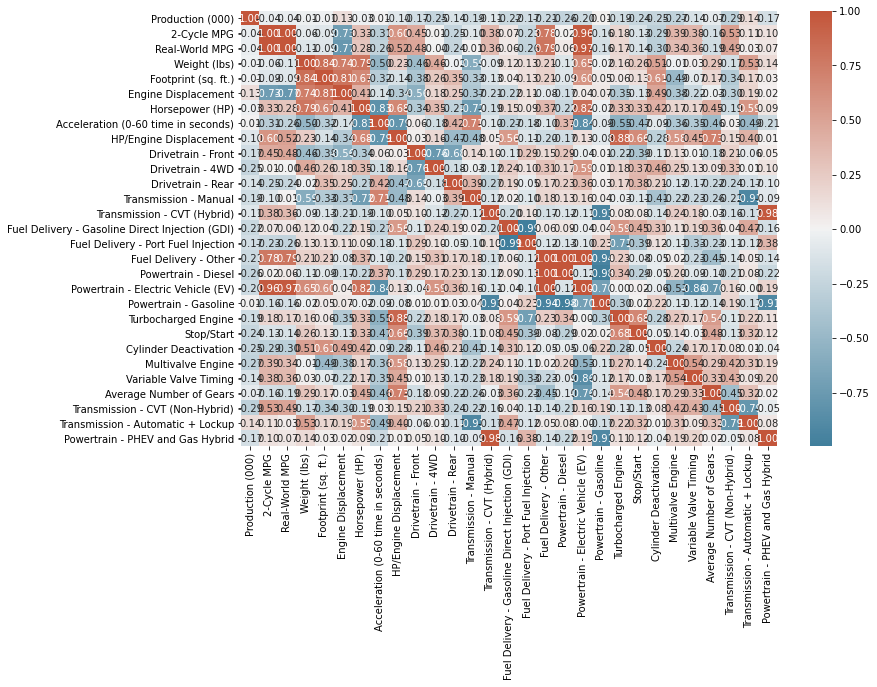

In [6]:
plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.drop(columns = ["Model Year", "Production Share"]).corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()